# 1D head diffusion

In [1]:
# Import modules and packages.
from matplotlib import pyplot
from scipy.sparse import coo_matrix
import numpy as np

%matplotlib inline

In [2]:
# Update default font family and size for Matplotlib figures.
pyplot.rc('font', family='serif', size=16)

## Discretization

$$
\frac{T_i^{n+1} - T_i^n}{\Delta t} = c_E \alpha \frac{T_{i-1}^n - 2 T_i^n + T_{i+1}^n}{\Delta x^2} + c_I \alpha \frac{T_{i-1}^{n+1} - 2 T_i^{n+1} + T_{i+1}^{n+1}}{\Delta x^2}
$$


* Forward Euler (explicit): $C_E = 1$, $C_I = 0$
* Backward Euler (implicit): $C_E = 0$, $C_I = 1$
* Crank-Nicolson (semi-implicit): $C_E = \frac{1}{2}$, $C_I = \frac{1}{2}$

Matrix-vector representation:

$$
\begin{split}
    &\left( \mathbf{I} - c_I \alpha \Delta t \mathbf{L} \right) T^{n+1} = \left( \mathbf{I} + c_E \alpha \Delta t \mathbf{L} \right) T^n + b_\text{b.c.} \\
    &\qquad \quad \Rightarrow \quad \mathbf{A} T^{n+1} = b
\end{split}
$$

## Parameters and initial conditions

In [3]:
# Set parameters.
L = 1.0  # length of the 1D domain
nx = 21  # number of spatial points.
dx = L / (nx - 1)  # spatial grid spacing
x = np.linspace(0.0, L, num=nx)  # spatial locations

alpha = 1.22e-3  # coefficient of diffusion
T_left = 100.0  # Fix temperature at the left boundary
q_right = 0.0  # Fix gradient at the right boundary

# Set initial solution at interior points.
T0 = np.zeros(nx - 2)

## Left-hand side operator

$$
\mathbf{A} = \mathbf{I} - c_I \alpha \Delta t \mathbf{L}
$$

where $\mathbf{I}$ is the identity operator and $\mathbf{L}$ is the 1D Laplacian operator.

### 1D Laplacian

$$
\nabla^2 T_i = \left. \frac{\partial^2 T}{\partial x^2} \right|_i = \frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x^2}
$$

$$
\mathbf{L} = \frac{1}{\Delta x^2}
\begin{bmatrix}
    -2 & 1 & & & \\
    1 & -2 & 1 & & (0) \\
    & \ddots & \ddots & \ddots & & \\
    (0) & & 1 & -2 & 1 \\
    & & & 1 & -1 \\
\end{bmatrix}
$$

In [4]:
def laplacian1d(N, dx):
    """Assemble the 1D Laplacian operator.
    
    Parameters
    ----------
    N : int
        Number of interior points (dimension of the square matrix).
    dx : float
        Spatial grid spacing.
        
    Returns
    -------
    numpy.ndarray
        The 1D Laplacian operator (as a 2D square matrix).
    
    """
    row1 = list(range(N))
    col1 = list(range(N))
    data1 = np.ones(N)*(-2 / dx**2)
    D = coo_matrix((data1, (row1, col1)), shape = (N,N)).toarray()
    D[-1,-1] = -1 / dx**2

    #U
    row2 = list(range(N-1))
    col2 = list(range(N-1)) + np.ones(N-1)
    data2 = np.ones(N-1) * (1 / dx**2)
    U = coo_matrix((data2, (row2, col2)), shape = (N,N)).toarray()
    
    #L
    row3 = list(range(N-1)) + np.ones(N-1)
    col3 = list(range(N-1))
    data3 = np.ones(N-1) * (1 / dx**2)
    L = coo_matrix((data3, (row3, col3)), shape = (N,N)).toarray()
    
    Lap = D + U + L
    
    return Lap

In [5]:
def lhs_operator(N, alpha, dt, cI, dx):
    """Assemble the left-hand side operator.
    
    Parameters
    ----------
    N : int
        Number of interior points (dimension of the square matrix).
    alpha : float
        Coefficient of diffusion.
    dt : float
        Time-step size.
    cI : float
        Implicit coefficient of the scheme.
    dx : float
        Spatial grid spacing.
    
    Returns
    -------
    numpy.ndarray
        The left-hand side operator (as a 2D square matrix).

    """
    row1 = list(range(N))
    col1 = list(range(N))
    data1 = np.ones(N)
    I = coo_matrix((data1, (row1, col1)), shape = (N,N)).toarray()
    # I = numpy.identity(N)
    
    L =  laplacian1d(N, dx)
    
    A = I - cI * alpha * dt *  L


    return A

## Right-hand side vector

$$
b = \left( \mathbf{I} + c_E \alpha \Delta t \mathbf{L} \right) T^n + b_\text{b.c.}
$$

In [6]:
def rhs_vector(T, N, alpha, dt, cE, dx, T_left, q_right):
    """Assemble the right-hand side vector.
    
    Parameters
    ----------
    T : numpy.ndarray
        Solution at previous time step.
    N : int
        Number of interior points (lenght of the RHS vector).
    alpha : float
        Coefficient of diffusion.
    cE : float
        Explicit coefficient of the scheme.
    dx : float
        Spatial grid spacing.
    T_left : float
        Temperature at the left boundary (Dirichlet condition).
    q_right : float
        Heat flux at the right boundary (Neumann condition).
        
    Returns
    -------
    numpy.ndarray
        The RHS vector (as a 1D array).

    """
    I = np.identity(N)
    
    L =  laplacian1d(N, dx)
    b_bc = np.zeros(N)
    sigma = alpha * dt / dx**2
    b_bc[0] = sigma * T_left
    b_bc[-1] = sigma * q_right * dx
    #b = numpy.dot(I + cE * alpha * dt * L, T) * T + b_bc
    b = (I + cE * alpha * dt * L)@T + b_bc
    
    return b

## Create the solver...

... such that we can use different numerical schemes.

In [7]:
def solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Forward Euler'):
    """Solve the system over a given number of time steps.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        Initial temperature field (as a 1D array).
    nt : int
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Spatial grid spacing.
    alpha : float
        Coefficient of diffusion.
    T_left : float
        Temperature at the left boundary (Dirichlet condition).
    q_right : float
        Heat flux at the right boundary (Neumann condition).
    method : str, optional
        The numerical scheme to use;
        choices are 'Forward Euler', 'Backward Euler',
        and `Crank-Nicolson`; default is 'Forward Euler'.
    
    Returns
    -------
    numpy.ndarray
        Temperature after given number of time steps (as a 1D array).

    """
    # Create a dictionary that maps the method's name
    # to the explicit and implicit coefficients of the scheme.
    coeffs = {'Forward Euler': (1.0, 0.0),
              'Backward Euler': (0.0, 1.0),
              'Crank-Nicolson': (0.5, 0.5)}
    cE, cI = coeffs[method]  # store the coefficients
    ###
    ### To do: compute the solution over nt time steps.
    ###
    T = T0.copy()
    N = T.size
    A = lhs_operator(N, alpha, dt, cI, dx)
    for n in range(nt):
        b = rhs_vector(T, N, alpha, dt, cE, dx, T_left, q_right)
        T = np.linalg.solve(A,b)
    
    return T

In [8]:
# Set temporal parameters.
sigma = 0.5  # CFL-like number
dt = sigma * dx**2 / alpha  # time-step size
nt = 10  # number of time steps.

T = solver(T0, nt, dt, dx, alpha, T_left, q_right, method='Crank-Nicolson')


In [9]:
def array_with_boundaries(T, T_left, q_right, dx):
    """Return an extended array with boundary values.
    
    Parameters
    ----------
    T : numpy.ndarray
        Solution at interior points.
    T_left : float
        Temperature at the left boundary (Dirichlet condition).
    q_right : float
        Heat flux at the right boundary (Neumann condition).
    dx : float
        Spatial grid spacing.
        
    Returns
    -------
    numpy.ndarray
        The extended solution (that includes boundary values).

    """
    T_right = T[-1] + q_right * dx
    T_ext = np.concatenate(([T_left], T, [T_right]))
    return T_ext

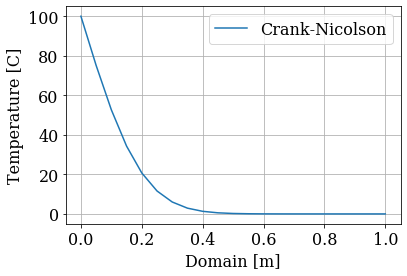

In [10]:
###
### To do: compute the extended solution (with boundary values)
###
T_ext = array_with_boundaries(T, T_left, q_right, dx)

###
### To do: plot the solution of the temperature.
###
pyplot.figure()
pyplot.xlabel('Domain [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()

pyplot.plot(x, T_ext, label = 'Crank-Nicolson')
pyplot.legend()

(0.0, 100.0)

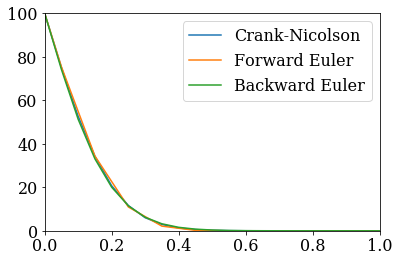

In [11]:
###
### To do: compute the solution with Forward Euler and Backward Euler.
###
T_ft = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Forward Euler')

T_bt = solver(T0, nt, dt, dx, alpha, T_left, q_right,
           method='Backward Euler')

###
### To do: plot the three solutions together.
###

pyplot.figure()
pyplot.plot(x, T_ext, label = 'Crank-Nicolson')
pyplot.plot(x, array_with_boundaries(T_ft, T_left, q_right, dx) , label = 'Forward Euler')
pyplot.plot(x, array_with_boundaries(T_bt, T_left, q_right, dx) , label = 'Backward Euler')

pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0)



## Analytical solution

$$
T \left( x, t \right) = 100 - \sum_{n=1}^\infty \frac{400}{(2n - 1) \pi} \sin \left( \frac{(2n - 1) \pi}{2L} x \right) \exp \left( -\alpha \left( \frac{(2n - 1) \pi}{2L} \right)^2 t \right)
$$

We can compute a truncated version of the analytical solution.

In [12]:
def analytical_temperature(x, t, alpha, L, N=100):
    """Compute a truncated exact solution.
    
    Parameters
    ----------
    x : numpy.ndarray
        The grid locations (as a 1D array of floats).
    t : float
        Time values.
    alpha : float
        Coefficient of diffusion.
    L : float
        Length of the domain.
    N : int, optional
        Number of terms to evaluate for the truncation solution;
        default: 100.
    
    Returns
    -------
    numpy.ndarray
        The truncated exact solution (as a 1D array).

    """
    ###
    ### To do: compute a truncated analytical solution.
    ###
    
    return T

In [13]:
###
### To do: compute the analytical solution with N = 100.
###


In [14]:
###
### To do: plot the Crank-Nicolson and analytical solutions together.
###


## Temporal convergence analysis

In [15]:
# Perform temporal convergence analysis.
nx = 1001  # number of spatial points in the domain
dx = L / (nx - 1)  # spatial grid spacing
x = numpy.linspace(0.0, L, num=nx)  # spatial locations

# Time-step sizes for which the solution will be computed.
dt_vals = [1.0, 0.5, 0.25, 0.125]

# List to store the relative L2-norms
errors_cn = []  # for Crank-Nicolson
errors_bt = []  # for Backward Euler

# Compute the initial solution.
t0 = 1.0
T0 = analytical_temperature(x[1:-1], t0, alpha, L)

# Compute the final solution.
tf = 10.0
T_e = analytical_temperature(x[1:-1], tf, alpha, L)

for dt in dt_vals:
    nt = int((tf - t0) / dt)
    ###
    ### To do: compute the relative L2-norm of the error for
    ### Crank-Nicolson and Backward Euler
    ### and for different time-step sizes.
    ### Append errors to `errors_cn` for Crank-Nicolson
    ### and to `errors_bt` for Backward Euler.
    ###
    

NameError: name 'numpy' is not defined

In [ ]:
###
### To do: plot the errors versus the time-step size
### (using a log/log plot).
###


What's the order of convergence in time for Crank-Nicolson and for Backward Euler?

## Spatial convergence analysis

In [ ]:
dt = 0.1  # time-step size
tf = 20.0  # final time
nt = int(tf / dt)  # number of time steps

# Spatial grid spacings for which the solution will be computed.
dx_vals = [0.1, 0.05, 0.025, 0.0125, 0.00625]

# List to store the relative L2-norm of the error.
errors = []

for dx in dx_vals:
    ###
    ### To do: compute the solution with Crank-Nicolson,
    ### compute the analytical solution,
    ### compute the relative L2-norm of the error.
    ###
    

In [ ]:
###
### To do: plot the errors versus the spatial grid spacing
### (using a log/log plot).
###


What's the order of convergence in space of the Crank-Nicolson method?

## Spatial convergence analysis at later time

In [ ]:
dt = 0.1  # time-step size
tf = 1000.0 # final time (we want the solution way later in time)
nt = int(tf / dt)  # number of time steps

# Spatial grid spacings for which the solution will be computed.
dx_vals = [0.1, 0.05, 0.025, 0.0125, 0.00625]

# List to store the relative L2-norm of the error.
errors = []

for dx in dx_vals:
    ###
    ### To do: compute the solution with Crank-Nicolson,
    ### compute the analytical solution,
    ### compute the relative L2-norm of the error.
    ###
    

In [ ]:
###
### To do: plot the errors versus the spatial grid spacing
### (using a log/log plot).
###


How is the spatial order of convergence affected?
And why?